In [1]:
import sys
import os
import platform
import importlib
import glob
import netCDF4

import numpy as np
import pandas as pd
import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = '/home/subin/data'
    cpuserver_data_FP = '/home/subin/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.ASCAT_TUW as hASCAT_TUW
import HydroAI.Grid as hGrid
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
importlib.reload(hASCAT_TUW);
importlib.reload(hPlot);
importlib.reload(hData);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

/home/subin/data /home/subin/cpuserver_data


## 1. Import and save ASCAT SM

In [2]:
year = 2022
path = 'am'
directory = os.path.join(cpuserver_data_FP, 'mat_files/ASCAT_h119_120/')
mat_file = directory + str(year) + '_ASCAT_SM_' + path + '_QC.mat'
ASCAT_SM, latitude, longitude = hASCAT_TUW.load_mat_file(mat_file, path)

In [3]:
np.shape(ASCAT_SM)

(3001, 6001, 365)

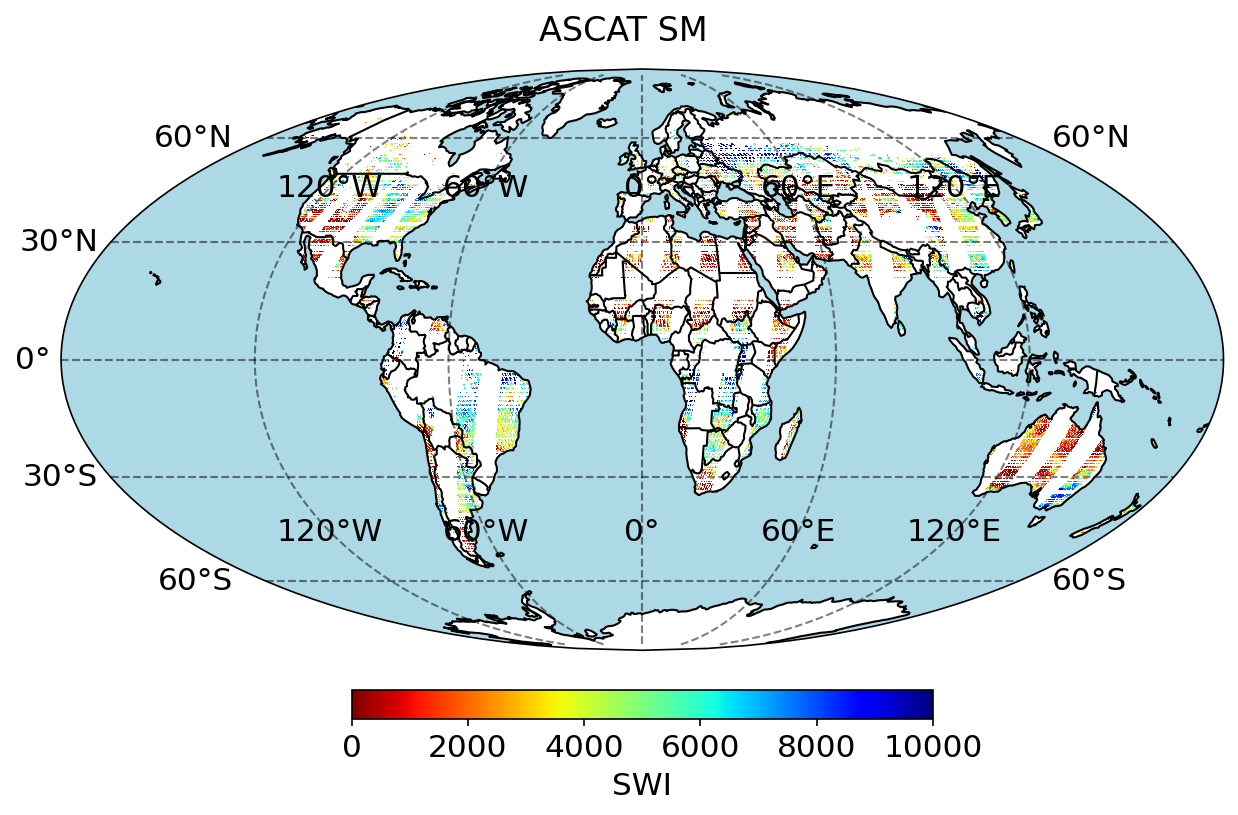

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [4]:
# Display the map with plot_global_map
doy = 109
target = ASCAT_SM
hPlot.plot_map(longitude, latitude, target[:, :, doy], np.nanmin(target), np.nanmax(target), plot_title='ASCAT SM', label_title='SWI', cmap='jet_r')

In [5]:
directory = os.path.join(cpuserver_data_FP, 'mat_files/ASCAT_h119_120/')

path_list = ['am', 'pm']
#for year in range(2015, 2023 + 1): 
for year in range(2023, 2023 + 1): 

    for path in path_list:
        print(year, path)
        mat_file = directory + str(year) + '_ASCAT_SM_' + path + '_QC.mat'
        
        # Import Variables
        ASCAT_SM, latitude, longitude = hASCAT_TUW.load_mat_file(mat_file, path)
        
        # Create a NetCDF file
        path_time = 'am' if path == 'am' else 'pm'
        file_name = f'ASCAT_TUW_{year}_{path_time}.nc'
        nc_file_name = os.path.join(nc_save_dir, file_name)

        time_suffix = 'AM' if path == 'am' else 'PM'

        print(f"Saving: {nc_file_name}")
        hData.create_netcdf_file(
        nc_file=nc_file_name, 
        latitude=latitude, 
        longitude=longitude,
        **{f'ASCAT_SM_{time_suffix}': ASCAT_SM})

        print(f"NetCDF file created: {nc_file_name}")

2023 am
Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc
2023 pm
Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc


## 2. Resample ASCAT data
1. SM data
2. Prosity data

In [6]:
target_projection = 'Noah_025'
#ASCAT_lon, ASCAT_lat = hGrid.generate_lon_lat_e2grid('25km')
ASCAT_lon, ASCAT_lat = longitude, latitude
hGrid.generate_lon_lat_e2grid('25km')
domain_lon, domain_lat = hGrid.generate_lon_lat_eqdgrid(0.25)
print(np.shape(ASCAT_lon), np.shape(ASCAT_lat))
print(np.shape(domain_lon), np.shape(domain_lat))

domain_lon = domain_lon[:600, :]
domain_lat = domain_lat[:600, :]
print(np.shape(domain_lon), np.shape(domain_lat))

path_list = ['am', 'pm']
#for year in range(2015, 2023 + 1): 
for year in range(2017, 2023 + 1): 
    
    for path in path_list:
        time_suffix = 'AM' if path == 'am' else 'PM'
        # resample ASCAT into the doamin size
        nc_file  = nc_save_dir+'/ASCAT_TUW_'+str(year)+'_'+path+'.nc'
        print(nc_file)
        nc_data  = netCDF4.Dataset(nc_file)
        ASCAT_SM  = nc_data.variables['ASCAT_SM_'+time_suffix][:].data
        nc_data.close()
        print(np.shape(ASCAT_SM))
        
        Resampled_ASCAT_SM    = hData.Resampling_forloop(domain_lon, domain_lat, ASCAT_lon, ASCAT_lat, ASCAT_SM)
        file_name = 'ASCAT_TUW_'+str(year)+'_'+path+'_R_'+target_projection+'.nc'
        nc_file_name = nc_save_dir+'/'+file_name
        
        print(f"Saving: {nc_file}")
        hData.create_netcdf_file(
        nc_file    = nc_file_name,
        latitude   = domain_lat,
        longitude  = domain_lon,
        Resampled_ASCAT_SM    = Resampled_ASCAT_SM)
        print(f"NetCDF file created: {nc_file}")

Processing row 0/584
Processing row 100/584
Processing row 200/584
Processing row 300/584
Processing row 400/584
Processing row 500/584
(3001, 6001) (3001, 6001)
(720, 1440) (720, 1440)
(600, 1440) (600, 1440)
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [44:34<00:00,  7.33s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:12<00:00,  7.43s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2017_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:34<00:00,  7.49s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:00<00:00,  7.40s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2018_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:15<00:00,  7.44s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [44:35<00:00,  7.33s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2019_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_am.nc
(3001, 6001, 366)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [45:55<00:00,  7.53s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_pm.nc
(3001, 6001, 366)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 366/366 [45:42<00:00,  7.49s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2020_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:45<00:00,  7.52s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:29<00:00,  7.48s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2021_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:06<00:00,  7.42s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [45:02<00:00,  7.40s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2022_pm.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [44:33<00:00,  7.33s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_am.nc
/home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc
(3001, 6001, 365)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [43:24<00:00,  7.14s/it]


Saving: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc
NetCDF file /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm_R_Noah_025.nc created successfully.
NetCDF file created: /home/subin/cpuserver_data/extracted_nc/ASCAT_TUW_2023_pm.nc


In [31]:
def read_nc_file(year, time, Resampled_product=None):  
    if Resampled_product == None:
        nc_file = os.path.join(cpuserver_data_FP, nc_save_dir, f'ASCAT_TUW_{year}_{time}.nc')
        time_suffix = 'AM' if time == 'am' else 'PM'
        SM_name = f'ASCAT_SM_{time_suffix}'
    else:
        nc_file = os.path.join(cpuserver_data_FP, nc_save_dir, f'ASCAT_TUW_{year}_{time}_R_{Resampled_product}.nc')
        SM_name = 'Resampled_ASCAT_SM'
    
    nc_data  = netCDF4.Dataset(nc_file)
    ASCAT_SM  = nc_data.variables[f'{SM_name}'][:].data
    ASCAT_lon = nc_data.variables['longitude'][:].data
    ASCAT_lat = nc_data.variables['latitude'][:].data
    nc_data.close()
    print(np.shape(ASCAT_SM))

    return ASCAT_SM, ASCAT_lon, ASCAT_lat

(3001, 6001, 365)


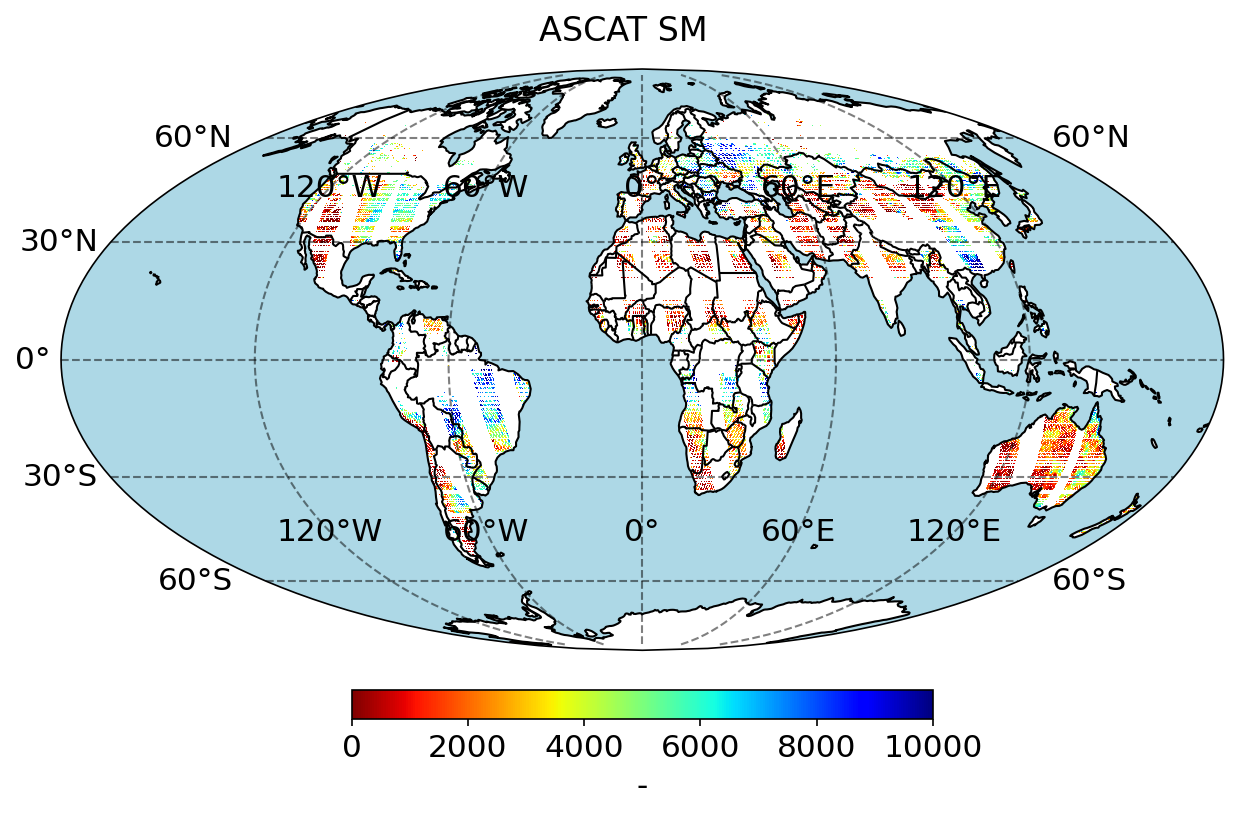

(600, 1440, 365)


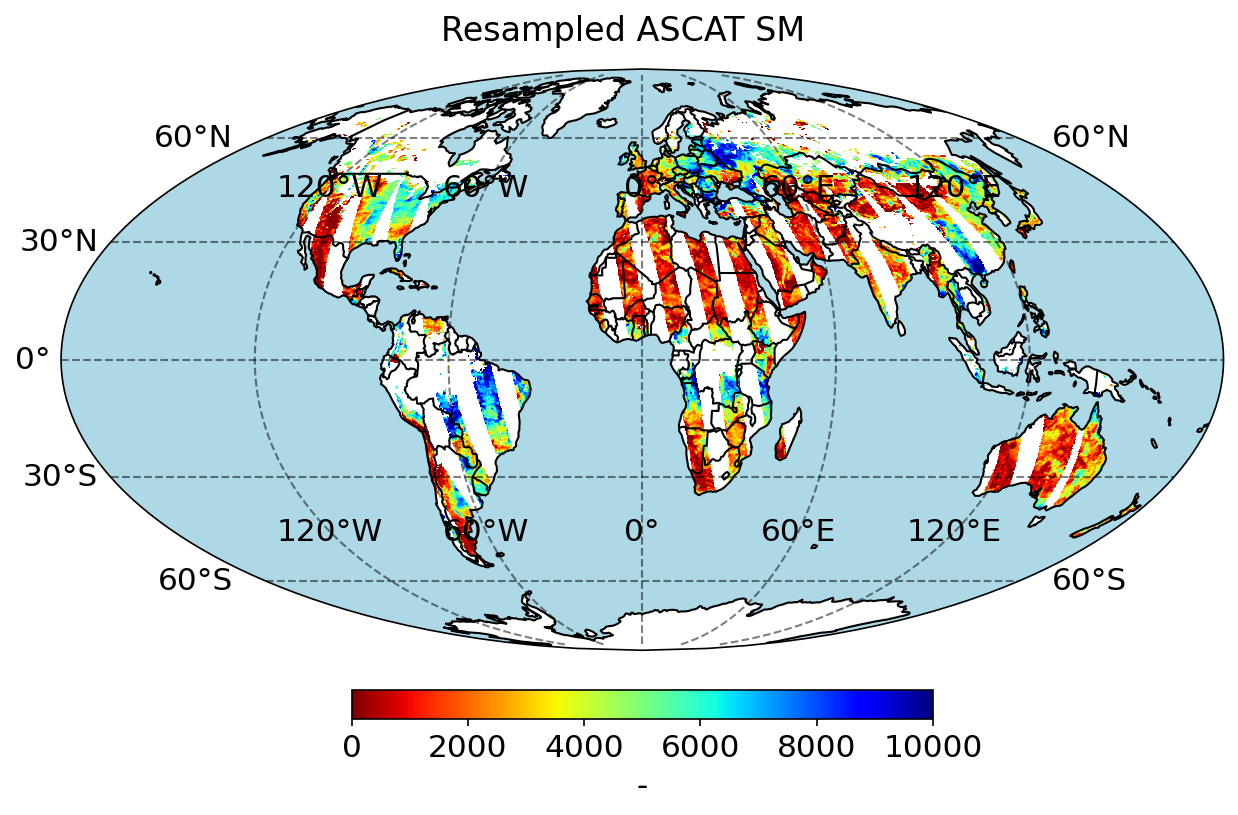

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [41]:
doy = 109
# Original
ASCAT_SM, ASCAT_lon, ASCAT_lat = read_nc_file(2021, 'pm')
target = ASCAT_SM[:,:, doy]
hPlot.plot_map(ASCAT_lon, ASCAT_lat, target, np.nanmin(target), np.nanmax(target), plot_title='ASCAT SM', label_title='-', cmap='jet_r')

# Resampled by Noah_025
Resampled_ASCAT_SM, Resampled_ASCAT_lon, Resampled_ASCAT_lat = read_nc_file(2021, 'pm', 'Noah_025')
target = Resampled_ASCAT_SM[:,:,doy]
hPlot.plot_map(Resampled_ASCAT_lon, Resampled_ASCAT_lat, target, np.nanmin(target), np.nanmax(target), plot_title='Resampled ASCAT SM', label_title='-', cmap='jet_r')

### No dataset in 2023

(3001, 6001, 365)


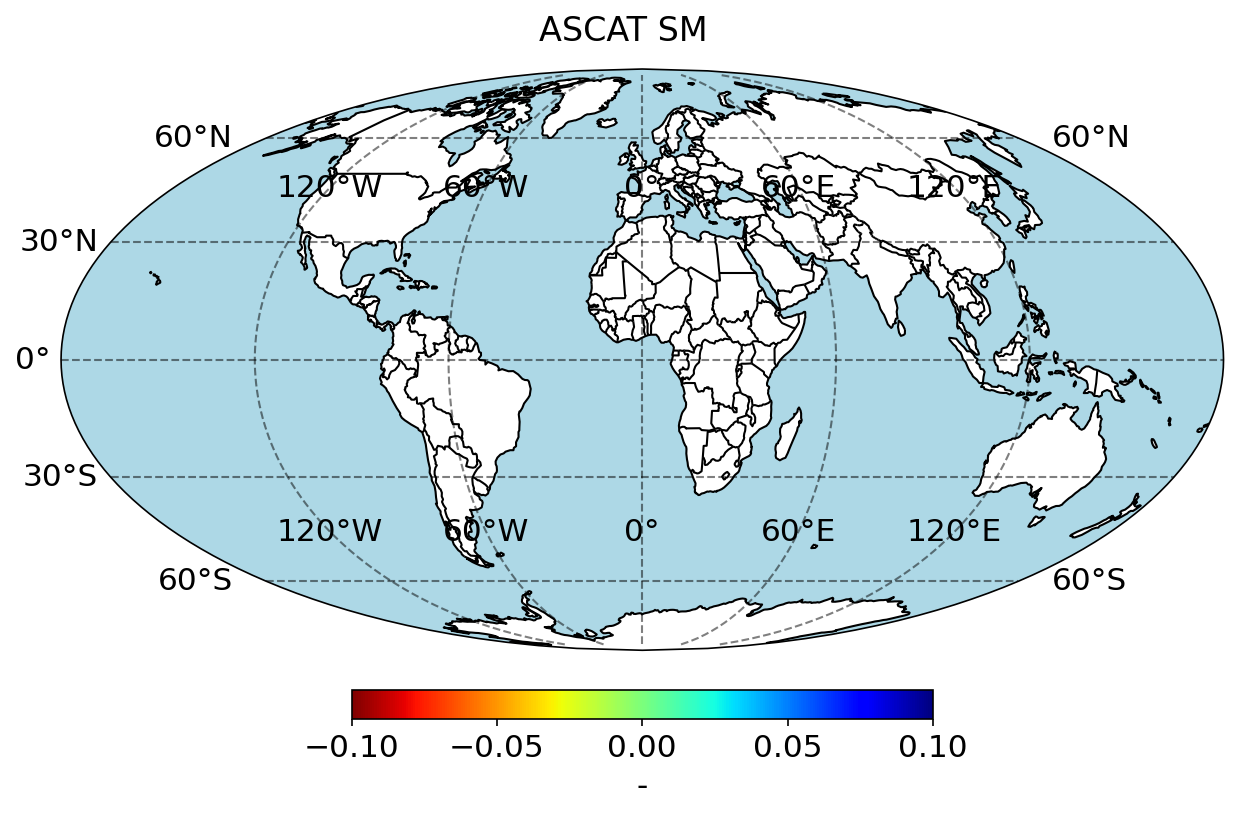

(600, 1440, 365)


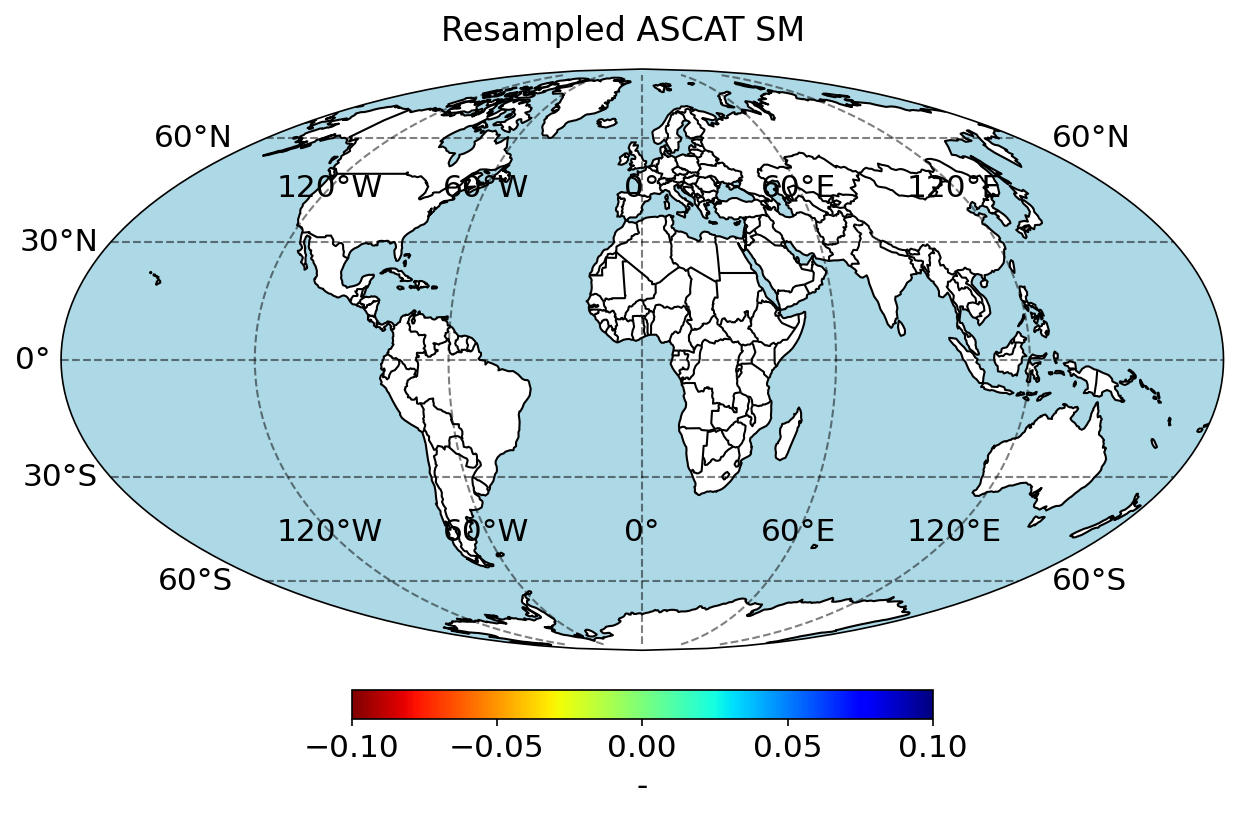

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [35]:
doy = 109
# Original
ASCAT_SM, ASCAT_lon, ASCAT_lat = read_nc_file(2023, 'pm')
target = ASCAT_SM[:,:, doy]
hPlot.plot_map(ASCAT_lon, ASCAT_lat, target, np.nanmin(target), np.nanmax(target), plot_title='ASCAT SM', label_title='-', cmap='jet_r')

# Resampled by Noah_025
Resampled_ASCAT_SM, Resampled_ASCAT_lon, Resampled_ASCAT_lat = read_nc_file(2023, 'pm', 'Noah_025')
target = Resampled_ASCAT_SM[:,:,doy]
hPlot.plot_map(Resampled_ASCAT_lon, Resampled_ASCAT_lat, target, np.nanmin(target), np.nanmax(target), plot_title='Resampled ASCAT SM', label_title='-', cmap='jet_r')